In [29]:
# Load csv as pandas dataframe
import pandas as pd


In [30]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Set headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',  # Do Not Track request header
}

# Function to extract tables from a given URL
def extract_table_from_url(url, required_columns, headers):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all tables with the target class
    tables = soup.find_all('table', class_='BlogTableTiling MyTable')
    
    print(f"Found {len(tables)} tables on {url}")
    
    tablesdf_combined = pd.DataFrame()  # Initialize empty DataFrame for all tables
    i = 0  # Counter to track number of matching tables
    
    # Iterate over found tables
    for table in tables:
        # Get the first row (headers)
        headers_row = table.find_all('tr')[0]
        headers = [td.get_text(strip=True) for td in headers_row.find_all('td')]
        
        # Normalize and remove extra spaces
        headers = [header.replace('\n', ' ').strip() for header in headers]

        # print(f"Extracted headers: {headers}")
        
        # Check if headers match the required columns
        if headers == required_columns:
            print(f"Found matching table {i + 1} on {url}")
            i += 1
            
            # If headers match, convert the table to a pandas DataFrame
            rows = []
            for row in table.find_all('tr')[1:]:
                row_data = []
                for idx, td in enumerate(row.find_all('td')):
                    # Check if it's the "BullishBearish" column (assuming it's the 3rd column based on the example)
                    if idx == 2:
                        bgcolor = td.get('bgcolor', '').lower()  # Get the background color and normalize case
                        if bgcolor == '#ff0000':
                            row_data.append(-1)  # Red color, mark as -1
                        elif bgcolor == '#008000':
                            row_data.append(1)  # Green color, mark as 1
                        else:
                            row_data.append(0)  # No color or other color, mark as 0 (or leave as is)
                    else:
                        row_data.append(td.get_text(strip=True))  # For all other columns
                rows.append(row_data)

            tabledf = pd.DataFrame(rows, columns=headers)
            
            # Concatenate the current DataFrame with the previously combined ones
            tablesdf_combined = pd.concat([tablesdf_combined, tabledf], ignore_index=True)
            
            # print(f"Table {i} extracted: \n{tabledf.head()}")  # Print the first few rows of the extracted table
            
    return tablesdf_combined




# Function to loop through months and years, extracting the required table
def scrape_tables(start_year, end_year, required_columns, headers):
    df_list = []
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    for year in range(start_year, end_year + 1):
        for month in months:
            url = f"https://thepatternsite.com/Blog-{month}{str(year)[-2:]}.html"
            print(f"Scraping {url}")

            # Extract table from the URL
            table_df = extract_table_from_url(url, required_columns, headers)
            
            if table_df is not None:
                df_list.append(table_df)
            else:
                print(f"No matching table found for {url}")
    
    # Concatenate all DataFrames into one
    if df_list:
        final_df = pd.concat(df_list, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()  # Return empty DataFrame if no tables were found

# Define the required columns for the table
required_columns = ['Symbol', 'Chart Pattern', 'BullishBearish', 'Start', 'End', 'Industry']

# Scrape tables from the blog pages between 2020 and 2024
final_data = scrape_tables(2020, 2024, required_columns, headers)

# Save the final DataFrame to a CSV file
final_data.to_csv('Datasets/scraped_blog_tables.csv', index=False)
print("Tables successfully scraped and saved to 'scraped_blog_tables.csv'")

# extract_table_from_url("https://thepatternsite.com/Blog-Jan20.html", required_columns, headers)


Scraping https://thepatternsite.com/Blog-Jan20.html
Found 23 tables on https://thepatternsite.com/Blog-Jan20.html
Found matching table 1 on https://thepatternsite.com/Blog-Jan20.html
Found matching table 2 on https://thepatternsite.com/Blog-Jan20.html
Found matching table 3 on https://thepatternsite.com/Blog-Jan20.html
Found matching table 4 on https://thepatternsite.com/Blog-Jan20.html
Scraping https://thepatternsite.com/Blog-Feb20.html
Found 22 tables on https://thepatternsite.com/Blog-Feb20.html
Found matching table 1 on https://thepatternsite.com/Blog-Feb20.html
Found matching table 2 on https://thepatternsite.com/Blog-Feb20.html
Found matching table 3 on https://thepatternsite.com/Blog-Feb20.html
Found matching table 4 on https://thepatternsite.com/Blog-Feb20.html
Scraping https://thepatternsite.com/Blog-Mar20.html
Found 33 tables on https://thepatternsite.com/Blog-Mar20.html
Found matching table 1 on https://thepatternsite.com/Blog-Mar20.html
Found matching table 2 on https://the

In [31]:
final_data

,Symbol,Chart Pattern,BullishBearish,Start,End,Industry
0,ACN,"Triangle, symmetrical",1,12/19/2019,01/30/2020,IT Services
1,ADS,Broadening top,-1,12/13/2019,01/24/2020,Information Services
2,AVY,Triple bottom,1,12/03/2019,01/27/2020,Packaging and Container
3,CMTL,Dead-cat bounce,-1,01/29/2020,01/29/2020,Telecom. Equipment
4,CSOD,Pipe top,-1,01/13/2020,01/21/2020,E-Commerce
...,...,...,...,...,...,...
9589,TXT,"Triangle, symmetrical",0,08/08/2024,10/03/2024,Diversified Co.
9590,TJX,"Double Top, Eve and Adam",0,08/28/2024,09/16/2024,Retail Store
9591,VEEV,"Double Top, Adam and Eve",0,08/29/2024,09/12/2024,Healthcare Information
9592,VMC,"Double Top, Adam and Adam",0,09/20/2024,09/26/2024,Cement and Aggregates


In [32]:


# Load csv as pandas dataframe
# cleanedPatternDf = pd.read_csv('Extracted Cleaned data of 2019 - 2024 chart patterns by Mr. Bulkowski.csv')
cleanedPatternDf = pd.read_csv('Datasets/scraped_blog_tables.csv')
cleanedPatternDf

,Symbol,Chart Pattern,BullishBearish,Start,End,Industry
0,ACN,"Triangle, symmetrical",1,12/19/2019,01/30/2020,IT Services
1,ADS,Broadening top,-1,12/13/2019,01/24/2020,Information Services
2,AVY,Triple bottom,1,12/03/2019,01/27/2020,Packaging and Container
3,CMTL,Dead-cat bounce,-1,01/29/2020,01/29/2020,Telecom. Equipment
4,CSOD,Pipe top,-1,01/13/2020,01/21/2020,E-Commerce
...,...,...,...,...,...,...
9589,TXT,"Triangle, symmetrical",0,08/08/2024,10/03/2024,Diversified Co.
9590,TJX,"Double Top, Eve and Adam",0,08/28/2024,09/16/2024,Retail Store
9591,VEEV,"Double Top, Adam and Eve",0,08/29/2024,09/12/2024,Healthcare Information
9592,VMC,"Double Top, Adam and Adam",0,09/20/2024,09/26/2024,Cement and Aggregates


In [33]:
# create a new df with the xolumn number of days from start to end of the pattern
patternDf = cleanedPatternDf.copy()
patternDf['Start'] = pd.to_datetime(patternDf['Start'])
patternDf['End'] = pd.to_datetime(patternDf['End'])
patternDf['Days'] = (patternDf['End'] - patternDf['Start']).dt.days
patternDf.head()


,Symbol,Chart Pattern,BullishBearish,Start,End,Industry,Days
0,ACN,"Triangle, symmetrical",1,2019-12-19,2020-01-30,IT Services,42
1,ADS,Broadening top,-1,2019-12-13,2020-01-24,Information Services,42
2,AVY,Triple bottom,1,2019-12-03,2020-01-27,Packaging and Container,55
3,CMTL,Dead-cat bounce,-1,2020-01-29,2020-01-29,Telecom. Equipment,0
4,CSOD,Pipe top,-1,2020-01-13,2020-01-21,E-Commerce,8


In [34]:
# get the min max and mean of the days
minDays = patternDf['Days'].min()
print("Min Days: ", minDays)

maxDaysDays = patternDf['Days'].max()
print("Max Days: ", maxDaysDays)

meanDays = patternDf['Days'].mean()
print("Mean Days: ", meanDays)

Min Days:  0
Max Days:  311
Mean Days:  22.626537419220345


In [35]:
# number of rows in the dataframe
numRows = len(patternDf)
print("Number of rows: ", numRows)

Number of rows:  9594


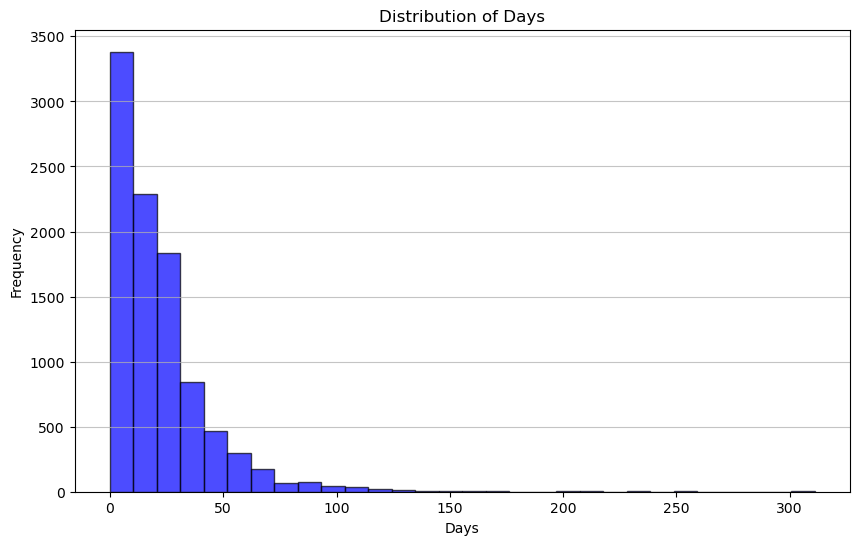

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your DataFrame as patternDf
# patternDf = pd.read_csv('your_data.csv') # Example of loading data if needed

# Plot a histogram to visualize the distribution of 'Days' data
plt.figure(figsize=(10, 6))
plt.hist(patternDf['Days'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Days')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()


In [37]:
# get the number of occurances of each values in the Symbol column
numberofTimes=cleanedPatternDf['Symbol'].value_counts()
numberofTimes

Symbol
HOV     40
AA      36
CENX    35
OUT     33
WLK     33
        ..
XLP      1
XLE      1
XLV      1
XHB      1
EVRG     1
Name: count, Length: 672, dtype: int64

In [38]:
#  get all the unique values in the Chart Pattern column 
uniquePatterns=cleanedPatternDf['Chart Pattern'].value_counts()
uniquePatterns.head(30)

Chart Pattern
Pipe bottom                     1432
Double Bottom, Adam and Adam     632
Pipe top                         597
Ugly double bottom               582
Triangle, symmetrical            542
Double Top, Adam and Adam        435
Triple bottom                    341
Triple top                       340
Head-and-shoulders top           339
Head-and-shoulders bottom        326
Dead-cat bounce                  303
Double Top, Eve and Eve          272
Double Top, Adam and Eve         267
Double Bottom, Eve and Adam      264
Flag, high and tight             241
Double Top, Eve and Adam         223
Double Bottom, Eve and Eve       215
Broadening top                   195
Double Bottom, Adam and Eve      183
Diamond top                      164
Broadening bottom                131
Triangle, ascending              130
Three Rising Valleys             126
Triangle, descending             107
Rectangle top                     82
Horn top                          80
Diamond bottom          

#### Selected patterns

Double Bottom, Adam and Adam 518

Triangle, symmetrical 483

Double Top, Adam and Adam 295

Double Bottom, Eve and Adam 208

Head-and-shoulders bottom 291

Head-and-shoulders top 263

Cup with handle 61


In [39]:
#  number of occurances of the Cup with handle pattern  
cupWithHandle=cleanedPatternDf['Chart Pattern'].str.contains('Cup with handle').sum()
cupWithHandle

66

In [40]:
# search for the row with the symbol 'AAPL' in numberofTimes
numberofTimes.loc['NVDA']


25

In [41]:
import os
import yfinance as yf
import pandas as pd
from datetime import datetime
from tqdm import tqdm

# Get today's date
end_date = datetime.today().strftime('%Y-%m-%d')

# Set to store symbols with errors
error_symbols = set()

# Create the "OHLS data" folder if it doesn't exist
output_directory = 'Datasets/OHLS data'
os.makedirs(output_directory, exist_ok=True)  # Creates the directory if it doesn't exist

# Assuming numberofTimes is already defined as a DataFrame
for symbol in tqdm(numberofTimes.index, desc="Downloading Data", unit="symbol"):
    try:
        # Download data with end date set to today's date
        data = yf.download(symbol, start='2020-01-01', end=end_date, progress=False)
        
        # Check if data is empty
        if data.empty:
            # print(f"No data found for {symbol}. It may be delisted or unavailable.")
            error_symbols.add(symbol)  # Add to error set
            continue
        
        # Save data to a CSV file
        data.to_csv(f'{output_directory}/{symbol}.csv')  # Save in the created folder
        
    except Exception as e:
        # print(f"Failed to download {symbol}: {str(e)}")
        error_symbols.add(symbol)  # Add to error set

# Print the symbols that encountered errors
if error_symbols:
    print("Symbols with download errors:")
    print(error_symbols)
else:
    print("All symbols downloaded successfully.")


1 Failed download:
['SLCA']: YFChartError('%ticker%: No data found, symbol may be delisted')
1 Failed download:
['GPS']: YFChartError('%ticker%: No data found, symbol may be delisted')
1 Failed download:
['CHS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['NVTA']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['CONN']: YFChartError('%ticker%: No data found, symbol may be delisted')
1 Failed download:
['HSC']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['BBBY']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['AEL']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['WIRE']: YFChartError('%ticker%: No data found, symbol may be delisted')
1 Failed download:
['AYX']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['RE']: YFTzMissingError('$%tick

$NWY: possibly delisted; No price data found  (1d 2020-01-01 -> 2024-11-04)



1 Failed download:
['JCP']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
1 Failed download:
['BLL']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')

Symbols with download errors:
{'NE', 'NVTA', 'HSC', 'COG', 'AEL', 'EIGI', 'NEWR', 'IVC', 'CLGX', 'ABC', 'AYX', 'JCP', 'BLL', 'BBBY', 'FB', 'NXGN', 'NCR', 'FOE', 'FLIR', 'FEYE', 'CY', 'ADS', 'AJRD', 'BRKS', 'MLHR', 'CONN', 'ANTM', 'NWY', 'CDAY', 'CSOD', 'NBL', 'JCOM', 'STMP', 'PXD', 'SPLK', 'CLR', 'TLRD', 'EPAY', 'PICO', 'GAP', 'KBAL', 'ETFC', 'ERA', 'MDC', 'GPS', 'CHS', 'CTXS', 'FFG', 'MDCA', 'SLCA', 'CREE', 'MNDT', 'XLNX', 'PKI', 'POL', 'LAWS', 'WIRE', 'MYL', 'ASNA', 'REV', 'AXE', 'RE'}


In [44]:
#  check for the empty csv files in the "OHLS data" folder
import os
import pandas as pd

# get the list of all the files in the "OHLS data" folder
files = os.listdir('Datasets/OHLS data')

emptyFiles = []

# check for the empty csv files in the "OHLS data" folder
for file in files:
    data = pd.read_csv('Datasets/OHLS data/'+file)
    if data.empty:
        # add the symbol of the empty csv file to the emptyFiles list
        emptyFiles.append(file)
        

print(emptyFiles)

[]


In [45]:
# number of empty files
len(emptyFiles)

0

In [46]:

# Normalize and remove the .CSV extension
emptyFiles = [symbol.strip().upper().replace('.CSV', '').replace('.CSV', '') for symbol in emptyFiles]


In [ ]:
import subprocess
import json
import pandas as pd
import os
from urllib.parse import urlencode
from datetime import datetime

def get_data(stock_id):
    url = f'https://api.investing.com/api/financialdata/historical/{stock_id}'
    params = {
        'start-date': '2020-07-01',
        'end-date': '2024-08-31',
        'time-frame': 'Daily',
        'add-missing-rows': 'false'
    }

    cnfg = ['curl', '-A', 'Chrome/128.0.0.0', '-H', 'domain-id: www', '-G', url, '-d', urlencode(params)]
    output = subprocess.run(cnfg, capture_output=True).stdout.decode()
    return json.loads(output)

def save_data_to_csv(stock_id, stock_data, folder_path="Datasets/OHLC_data"):
    os.makedirs(folder_path, exist_ok=True)
    
    columns = ['Price', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'Date']
    data_rows = []

    # Parse and format the data into a list of dictionaries
    for entry in stock_data.get('data', []):
        date = datetime.utcfromtimestamp(entry['rowDateRaw']).strftime('%Y-%m-%d %H:%M:%S+00:00')
        data_rows.append({
            'Price': entry['last_closeRaw'],
            'Adj Close': entry['last_closeRaw'],
            'Close': entry['last_closeRaw'],
            'High': entry['last_maxRaw'],
            'Low': entry['last_minRaw'],
            'Open': entry['last_openRaw'],
            'Volume': entry['volumeRaw'],
            'Ticker': stock_id,
            'Date': date
        })

    df = pd.DataFrame(data_rows, columns=columns)
    
    file_path = os.path.join(folder_path, f"{stock_id}.csv")
    
    df.to_csv(file_path, index=False)


In [ ]:
stocks = {
    'WIRE': '17555',   # Encore Wire Corp
    'CSOD': '15833',   # Cornerstone OnDemand Inc
    'BBBY': '6389',   # Bed Bath & Beyond Inc
    'STMP': '17267',   # Stamps.com Inc
    'RE': '20171',     # Everest Re Group Ltd (assuming you meant Everest Re)
    'COG': '13835',    # Cabot Oil & Gas Corporation
    'KBAL': '16443',   # Kimball International, Inc.
    'ADS': '32507',    # Alliance Data Systems Corp
    'ERA': '41207',    # Era Group Inc
    'NWY': '8130',     # New York & Company Inc
    'ANTM': '958110',   # Anthem Inc
    'SLCA': '29673',  # U.S. Silica Holdings Inc
    'ABC': '8060',    # AmerisourceBergen Corp
    # 'NVTA': '',  # Invitae Corp
    # 'XLNX': '',   # Xilinx Inc
    # 'CHS': '',     # Chico's FAS Inc.
    # 'ASNA': '',    # Ascena Retail Group
    # 'CLR': '111508',   # Continental Resources Inc.
    # 'FLIR': '3038',    # FLIR Systems Inc
    # 'HSC': '20517',    # Harsco Corp
    # 'AJRD': '17292',   # Aerojet Rocketdyne Holdings Inc
    # 'AYX': '159875',   # Alteryx, Inc
    # 'CREE': '3021',    # Cree Inc
    # 'LAWS': '17022',   # Lawson Products
    # 'TLRD': '28820',   # Tailored Brands Inc
    # 'CONN': '2969',    # Conn's Inc
    # 'REV': '2560',     # Revlon Inc
    # 'JCP': '20306',    # J.C. Penney Company Inc
    # 'NBL': '2971',     # Noble Energy Inc.
    # 'AEL': '20560',    # American Equity Investment Life Holding
    # 'CY': '20461',     # Cypress Semiconductor
    # 'IVC': '2888',     # Invacare Corp.
    # 'FFG': '17260',    # FBL Financial Group
    # 'POL': '21312',    # PolyOne Corp
    # 'MDC': '24784',    # MDC Holdings Inc.
    # 'EIGI': '26314',   # Endurance International Group Holdings
    # 'NXGN': '115196',  # NextGen Healthcare Inc
    # 'AXE': '20499',    # Anixter International Inc
    # 'PICO': '24805',   # PICO Holdings
    # 'JCOM': '17282',   # J2 Global Inc.
    # 'MYL': '11510',    # Mylan Laboratories Inc.
    # 'MLHR': '2704',    # Miller, Herman Inc.
    # 'FOE': '20616',    # Ferro Corp
    # 'CLGX': '25655',   # CoreLogic Inc
    # 'FEYE': '988464'   # FireEye Inc
}


In [ ]:
for ticker, stock_id in stocks.items():
    data = get_data(stock_id)
    save_data_to_csv(ticker, data)

In [47]:
# coppy the error_symbols set to a new set
all_error_symbols = error_symbols.copy()

# convert the emptyFiles list to a set and append it to the all_error_symbols set
all_error_symbols.update(set(emptyFiles))

# number of symbols with errors
print(len(all_error_symbols))

print("Symbols with download errors:")
print(all_error_symbols)

62
Symbols with download errors:
{'NE', 'NVTA', 'HSC', 'COG', 'AEL', 'EIGI', 'NEWR', 'IVC', 'CLGX', 'ABC', 'AYX', 'JCP', 'BLL', 'BBBY', 'FB', 'NXGN', 'NCR', 'FOE', 'FLIR', 'FEYE', 'CY', 'ADS', 'AJRD', 'BRKS', 'MLHR', 'CONN', 'ANTM', 'NWY', 'CDAY', 'CSOD', 'NBL', 'JCOM', 'STMP', 'PXD', 'SPLK', 'CLR', 'TLRD', 'EPAY', 'PICO', 'GAP', 'KBAL', 'ETFC', 'ERA', 'MDC', 'GPS', 'CHS', 'CTXS', 'FFG', 'MDCA', 'SLCA', 'CREE', 'MNDT', 'XLNX', 'PKI', 'POL', 'LAWS', 'WIRE', 'MYL', 'ASNA', 'REV', 'AXE', 'RE'}


In [48]:
patternDf['Symbol'] = patternDf['Symbol'].str.strip().str.upper()
all_error_symbols = [symbol.strip().upper() for symbol in all_error_symbols]

In [49]:
# Get the number of rows for each chart pattern of any symbol that has an empty csv file
pattern_count = patternDf[patternDf['Symbol'].isin(all_error_symbols)]['Chart Pattern'].value_counts()

print("Pattern counts for symbols with empty CSV files:", pattern_count)


Pattern counts for symbols with empty CSV files: Chart Pattern
Pipe bottom                                    70
Dead-cat bounce                                53
Flag, high and tight                           38
Pipe top                                       31
Triangle, symmetrical                          27
Double Top, Adam and Adam                      21
Double Bottom, Adam and Adam                   18
Ugly double bottom                             18
Head-and-shoulders bottom                      16
Head-and-shoulders top                         12
Diamond top                                    10
Triple bottom                                  10
Double Top, Eve and Adam                       10
Triangle, ascending                             9
Rectangle bottom                                8
Double Bottom, Eve and Adam                     8
Double Top, Eve and Eve                         7
Triple top                                      6
Triangle, descending                 

In [50]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Set headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',  # Do Not Track request header
}

# Function to extract full stock names from a given URL based on short names
def extract_full_names_from_url(url, short_names, headers):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    print(f"Scraping {url}")

    full_names = {}

    # Iterate over the short names and find their full names in the HTML
    for short_name in short_names.copy():  # Copy the list to avoid modifying during iteration
        # Search for the short name in the text
        entry = soup.find('div', text=lambda x: x and short_name in x)
        if entry:
            # Get the bold text (full name)
            bold_text = entry.find('span', style=lambda x: x and 'font-weight: bold;' in x)
            if bold_text:
                full_names[short_name] = bold_text.text.strip()
                print(f"Found full name for {short_name}: {full_names[short_name]}")
                # remove the found short name from the list
                short_names.remove(short_name)

    return full_names

# Function to loop through months and years, extracting full names
def scrape_full_names(start_year, end_year, short_names, headers):
    all_full_names = {}
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    
    short_names_copy = short_names.copy()  # Create a copy of the list to avoid modifying the original

    for year in range(start_year, end_year + 1):
        for month in months:
            url = f"https://thepatternsite.com/Blog-{month}{str(year)[-2:]}.html"
            
            # Check if the short names list is empty, break if it is
            if not short_names_copy:
                break
            
            # Extract full names from the URL
            full_names = extract_full_names_from_url(url, short_names_copy, headers)
            all_full_names.update(full_names)  # Update the dictionary with found names

        # After each month loop, check again if short_names_copy is empty
        if not short_names_copy:
            break

    return all_full_names

# Scrape full names from the blog pages between 2020 and 2024
full_names_data = scrape_full_names(2020, 2024, all_error_symbols, headers)

# Convert the result to a DataFrame
full_names_df = pd.DataFrame(list(full_names_data.items()), columns=['Short Name', 'Full Name'])

# Set the index to be the short names
full_names_df.set_index('Short Name', inplace=True)

# Save the DataFrame to a CSV file
full_names_df.to_csv('Datasets/scraped_full_names.csv', index=True)
print("Full names successfully scraped and saved to 'scraped_full_names.csv'")



Scraping https://thepatternsite.com/Blog-Jan20.html
Found full name for NE: Clean Energy Fuels Corp. (CLNE)
Found full name for COG: Cabot Oil and Gas A (COG)
Found full name for BBBY: Bed Bath and Beyond (BBBY)
Found full name for ADS: Alliance Data Systems Corp (ADS)


C:\Users\gwiku\AppData\Local\Temp\ipykernel_18720\880998671.py:27: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



Found full name for NWY: New York and Company Inc (NWY)
Found full name for CSOD: Cornerstone OnDemand Inc (CSOD)
Found full name for STMP: Stamps.com (STMP)
Found full name for KBAL: Kimball International, Inc. (KBAL)
Found full name for ERA: Era Group Inc (ERA)
Found full name for WIRE: Encore Wire Corp (WIRE)
Found full name for RE: Encore Wire Corp (WIRE)
Scraping https://thepatternsite.com/Blog-Feb20.html
Found full name for NVTA: Invitae Corp (NVTA)
Found full name for HSC: Harsco Corp (HSC)
Found full name for ABC: AmerisourceBergen Corp (ABC)
Found full name for AYX: Alteryx, Inc (AYX)
Found full name for FLIR: Flir Systems Inc (FLIR)
Found full name for AJRD: Aerojet Rocketdyne (AJRD)
Found full name for ANTM: Anthem (ANTM)
Found full name for CLR: Continental Resources Inc. (CLR)
Found full name for TLRD: Tailored Brands Inc (TLRD)
Found full name for GPS: Gap Inc. (GPS)
Found full name for CHS: Chicos FAS Inc. (CHS)
Found full name for SLCA: U.S Silica Holdings Inc (SLCA)
Fo

In [51]:
full_names_df

,Full Name
Short Name,
NE,Clean Energy Fuels Corp. (CLNE)
COG,Cabot Oil and Gas A (COG)
BBBY,Bed Bath and Beyond (BBBY)
ADS,Alliance Data Systems Corp (ADS)
NWY,New York and Company Inc (NWY)
CSOD,Cornerstone OnDemand Inc (CSOD)
STMP,Stamps.com (STMP)
KBAL,"Kimball International, Inc. (KBAL)"
ERA,Era Group Inc (ERA)


In [52]:
# Initialize an empty list to store the data
data = []

for file in emptyFiles:
    # Create a temporary dictionary with the current 'Symbol' and 'Times'
    temp_dict = {
        'Symbol': file[:-4],
        'Times': numberofTimes.loc[file[:-4]]
    }
    # Append the dictionary to the list
    data.append(temp_dict)

# Create the DataFrame from the list of dictionaries
nullfilesPatternTimesDf = pd.DataFrame(data)

nullfilesPatternTimesDf

""


In [53]:
# #  delete the empty csv files in the "OHLS data" folder and ""OHLS data pattern added" folder
# import os

# # get the list of all the files in the "OHLS data" folder
# files = os.listdir('OHLS data')

# # delete the empty csv files in the "OHLS data" folder
# for file in emptyFiles:
#     os.remove
#     ('OHLS data/'+file)
#     print(file)
#     print('---------------------------------------------')
    


In [55]:
# from the ""OHLS data" folder get te "NVDA.csv" file which has these columns now : Date,Open,High,Low,Close,Adj Close,Volume , and plot the candle stick pattern chart and mark the chart pattern on the chart by using the start and end date of the each chart pattern for the symbol 'NVDA' in the cleanedPatternDf dataframe where it has Symbol,Chart Pattern,Bullish/Bearish,Start,End columns 

import pandas as pd

# Load NVDA CSV file
nvda_df = pd.read_csv("Datasets/OHLS data/NVDA.csv")

# Ensure the Date column is of datetime type
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'])

# Set the Date as the index
nvda_df.set_index('Date', inplace=True)



In [56]:
cleanedPatternDf

,Symbol,Chart Pattern,BullishBearish,Start,End,Industry
0,ACN,"Triangle, symmetrical",1,12/19/2019,01/30/2020,IT Services
1,ADS,Broadening top,-1,12/13/2019,01/24/2020,Information Services
2,AVY,Triple bottom,1,12/03/2019,01/27/2020,Packaging and Container
3,CMTL,Dead-cat bounce,-1,01/29/2020,01/29/2020,Telecom. Equipment
4,CSOD,Pipe top,-1,01/13/2020,01/21/2020,E-Commerce
...,...,...,...,...,...,...
9589,TXT,"Triangle, symmetrical",0,08/08/2024,10/03/2024,Diversified Co.
9590,TJX,"Double Top, Eve and Adam",0,08/28/2024,09/16/2024,Retail Store
9591,VEEV,"Double Top, Adam and Eve",0,08/29/2024,09/12/2024,Healthcare Information
9592,VMC,"Double Top, Adam and Adam",0,09/20/2024,09/26/2024,Cement and Aggregates


In [58]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Read CSV Data
nvda_df = pd.read_csv('Datasets/OHLS data/GOOGL.csv')

# Step 2: Prepare Data
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'])

# Step 3: Plot Candlestick Chart
fig = go.Figure(data=[go.Candlestick(x=nvda_df['Date'],
                                     open=nvda_df['Open'],
                                     high=nvda_df['High'],
                                     low=nvda_df['Low'],
                                     close=nvda_df['Close'])])

# Step 4: Prepare cleanedPatternDf

cleanedPatternDf['Start'] = pd.to_datetime(cleanedPatternDf['Start'])
cleanedPatternDf['End'] = pd.to_datetime(cleanedPatternDf['End'])

# Step 5: Mark Patterns
for index, row in cleanedPatternDf.iterrows():
    if row['Symbol'] == 'GOOGL':
        start_date = row['Start']
        end_date = row['End']
        pattern = row['Chart Pattern']
        color = 'rgba(0, 0, 255, 0.2)' if row['BullishBearish'] == 'Bullish' else 'rgba(255, 0, 0, 0.2)'
        
        # Add shaded area for pattern range
        fig.add_shape(
            type="rect",
            xref="x",
            yref="paper",
            x0=start_date,
            y0=0,
            x1=end_date,
            y1=1,
            fillcolor=color,
            opacity=0.2,
            layer="below",
            line_width=0,
        )
        
        # Add annotation for pattern
        fig.add_annotation(x=start_date, y=nvda_df['High'].max(), text=pattern, showarrow=True, arrowhead=1)

# Step 6: Adjust Layout for Height and Zoom Controls
fig.update_layout(
    title='GOOGL Candlestick Chart with Pattern Annotations',
    height=800,
    autosize=True,
    yaxis={'fixedrange': False},
    xaxis={'fixedrange': False, 'rangeslider': {'visible': True}}
)

# Step 7: Display Chart
fig.show()


In [59]:
# get all the data in cleanedPatternDf where symbol is 'NVDA'
cleanedPatternDf[cleanedPatternDf['Symbol'] == 'BBBY']

,Symbol,Chart Pattern,BullishBearish,Start,End,Industry
50,BBBY,Dead-cat bounce,-1,2020-01-09,2020-01-09,Retail (Special Lines)
116,BBBY,Dead-cat bounce,-1,2020-02-12,2020-02-12,Retail (Special Lines)
354,BBBY,"Flag, high and tight",1,2020-04-03,2020-05-28,Retail (Special Lines)
643,BBBY,Dead-cat bounce,-1,2020-07-09,2020-07-09,Retail (Special Lines)
786,BBBY,Broadening top,-1,2020-08-10,2020-09-09,Retail (Special Lines)
972,BBBY,"Flag, high and tight",1,2020-07-31,2020-10-01,Retail (Special Lines)
1680,BBBY,"Triangle, descending",-1,2021-04-15,2021-05-20,Retail (Special Lines)
1903,BBBY,Pipe bottom,1,2021-06-14,2021-06-21,Retail (Special Lines)
2053,BBBY,"Broadening top, right-angled and descending",1,2021-07-29,2021-09-08,Retail (Special Lines)
2787,BBBY,Three Falling Peaks,-1,2022-02-01,2022-02-16,Retail (Special Lines)


In [61]:
import pandas as pd
import plotly.graph_objects as go
import random


pattern = 'Dead-cat bounce'
n = 15

# Get all the rows with 'Head-and-shoulders top' chart pattern
head_and_shoulders_df = cleanedPatternDf[cleanedPatternDf['Chart Pattern'] == pattern]

# Get a random sample of 10 rows
random_head_and_shoulders_df = head_and_shoulders_df.sample(n=n)

# Initialize the figure
fig = go.Figure()

# Loop through the random sample
for index, row in random_head_and_shoulders_df.iterrows():
    symbol = row['Symbol']
    start_date = row['Start']
    end_date = row['End']
    
    # Adjust the date range to include a 5-day padding
    padded_start_date = start_date - pd.Timedelta(days=0)
    padded_end_date = end_date + pd.Timedelta(days=0)
    
    # Read the CSV file for the symbol but efore check if the csv file exists , if not skip this iteration
    try:
        symbol_df = pd.read_csv(f'Datasets/OHLS data/{symbol}.csv')
    except FileNotFoundError:
        # print(f"Data not found for {symbol}. Skipping...")
        continue

    # convert the data column to datetime type
    symbol_df['Date'] = pd.to_datetime(symbol_df['Date'])

    
    # Filter the DataFrame to include only the date range of the pattern with padding
    symbol_df_filtered = symbol_df[(symbol_df['Date'] >= padded_start_date) & (symbol_df['Date'] <= padded_end_date)]
    
    # Add the candlestick chart for the filtered date range
    fig.add_trace(go.Candlestick(x=symbol_df_filtered['Date'],
                                 open=symbol_df_filtered['Open'],
                                 high=symbol_df_filtered['High'],
                                 low=symbol_df_filtered['Low'],
                                 close=symbol_df_filtered['Close'],
                                 name=symbol))
    
    # Add shaded area for pattern range
    fig.add_shape(
        type="rect",
        xref="x",
        yref="paper",
        x0=start_date,
        y0=0,
        x1=end_date,
        y1=1,
        fillcolor='rgba(0, 0, 255, 0.2)',
        opacity=0.2,
        layer="below",
        line_width=0,
    )
    
    # Add annotation for pattern
    fig.add_annotation(x=start_date, y=symbol_df_filtered['High'].max(), text=pattern, showarrow=True, arrowhead=1)

# Update the layout
fig.update_layout(
    title=pattern+' Candlestick Chart with Pattern Annotations',
    height=800,
    autosize=True,
    yaxis={'fixedrange': False},
    xaxis={'fixedrange': False, 'rangeslider': {'visible': True}}
)

# Display the chart
fig.show()
